In [1]:

import pandas as pd
import numpy as np
from scipy import spatial
from spacy.lang.en import English
import pickle
import random



In [11]:
nlp = English().from_disk('../../../spacymodelnew')


In [12]:
df=pd.read_csv('../../../stories.csv', index_col=0)

In [13]:
df['vectors']=pickle.load(open( "../../../vector.p", "rb" ))

In [9]:
df.head()

,story_title,story_text,book_id,book_author,book_title,word_count
0,The Orchard's Grandmother,I must ask you to go back more than two hundre...,30720,Various,Happy Days for Boys and Girls,4438
1,Rough,"He was a donkey, and we called him Rough. He b...",30720,Various,Happy Days for Boys and Girls,1975
2,The Music Lesson,"Touch the keys lightly, Nellie, my dear: ...",30720,Various,Happy Days for Boys and Girls,77
3,The Frost,"The frost looked forth one still clear night, ...",30720,Various,Happy Days for Boys and Girls,343
4,My Picture,I have a little picture; Perchance you have...,30720,Various,Happy Days for Boys and Girls,260


### Functions

In [76]:
def similarity(vec1, vec2):
    return 1- spatial.distance.cosine(vec1, vec2)

def query(user_input):
    doc=nlp(user_input)
    input_vector=doc.vector

    unsorted_sim=[(i, similarity(input_vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
    results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
    return results

def sample_results(results, n=12):
    strong_options=results[:n]
    medium_options=results[n:2*n]
    weak_options=results[2*n:3*n]

    sampled_items=[]
    for index in range(n//3):
        new_group= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
        sampled_items+=new_group
    return sampled_items

def make_story_dict(story_id, similarity=None):
    new_story_dict={}
    new_story_dict['story_title']=df.loc[story_id,'story_title']
    new_story_dict['book_title']=df.loc[story_id, 'book_title']
    new_story_dict['book_author']=df.loc[story_id,'book_author']
    new_story_dict['similarity']= similarity
    est_time=df.loc[story_id, 'word_count']//250 +1
    if est_time>1:
        new_story_dict['time_length']="About "+str(est_time)+" minutes"
    else:
        new_story_dict['time_length']="About "+str(est_time)+" minute"
    new_story_dict['story_id']=story_id

    for key, value in new_story_dict.items():
        if value=='frozenset()':
            new_story_dict[key]='Unknown'
    return new_story_dict

def find_similar_stories(story_id):
    story_vector=df.loc[story_id, 'vectors']
    unsorted_sim=[(i, similarity(story_vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
    results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
    return results[1:]


In [14]:
def query(user_input):
    doc=nlp(user_input)
    input_vector=doc.vector
    unsorted_sim=[(i, similarity(doc.vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>120]
    results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
    return results


In [78]:
query('aladdin')

[(3311, 0.6091477274894714),
 (15402, 0.6018624901771545),
 (5430, 0.5873239636421204),
 (3379, 0.5829311609268188),
 (17519, 0.5825258493423462),
 (10983, 0.5812482237815857),
 (4358, 0.5800289511680603),
 (17520, 0.5798356533050537),
 (9194, 0.5738510489463806),
 (9746, 0.5722767114639282),
 (3309, 0.5667421817779541),
 (9321, 0.5657677054405212),
 (6441, 0.5656152367591858),
 (6439, 0.5632753372192383),
 (17521, 0.5622010231018066),
 (3382, 0.5606428384780884),
 (3340, 0.555571436882019),
 (3313, 0.5544307827949524),
 (3378, 0.5541473031044006),
 (4171, 0.5541072487831116),
 (5266, 0.5520795583724976),
 (2779, 0.5504959225654602),
 (3381, 0.5500492453575134),
 (4093, 0.5495575666427612),
 (3328, 0.5471053719520569),
 (1129, 0.5465529561042786),
 (11017, 0.5464155673980713),
 (14784, 0.5456480383872986),
 (3327, 0.5455276966094971),
 (4091, 0.5452726483345032),
 (3375, 0.5447824597358704),
 (3315, 0.5443986654281616),
 (10439, 0.5439931750297546),
 (3380, 0.5431044697761536),
 (3335,

In [17]:
title_docs=list(nlp.pipe(df.story_text, batch_size=100, cleanup=True, n_process=-1))

In [18]:
df['title_vectors']=[x.vector for x in title_docs]

# Single Word Query Tests

1. First tried to turn titles into vectors
->If verb not in query, return similar stories to the most likely story

### 1.Title as Vectors

As an initial test, the first function used titles vectorized from the nlp.pipe used on the story data.

In [106]:
def title_vector_query(user_input):
    doc=nlp(user_input)
    input_vector=doc.vector

    unsorted_sim=[(i, similarity(input_vector, df.loc[i, 'title_vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
    results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
    return results

The function title_vector_query does not return the Aladdin story

In [111]:
[(df.loc[result[0], 'story_title'], result[1]) for result in title_vector_query('Aladdin')[:10]]

[('“Rap! Rap! Rap!”', 0.5359121561050415),
 ('Midwinter', 0.5075991153717041),
 ('List Of Best Books Of Classic Tales And Old-Fashioned Stories',
  0.5003886818885803),
 ('Contributors', 0.4974963963031769),
 ('List Of Maps', 0.4967570900917053),
 ("Jonathan Swift. Gulliver's Travels", 0.4959324300289154),
 ('Christmas Everywhere', 0.49445590376853943),
 ('Scandinavian Stories', 0.49196189641952515),
 ('Bibliography Of Fairy Tales', 0.4895022213459015),
 ('Some Old Favorites', 0.4833475351333618)]

In [108]:
### Here are the original query function's results for comparison
[(df.loc[result[0], 'story_title'], result[1]) for result in query('Aladdin')[:10]]

[('Bibliography Of Fairy Tales', 0.6091477274894714),
 ('The History Of Ali Baba, And Of The Forty', 0.6018624901771545),
 ("List Of Best Books Of Fairy Tales And Children's Poems",
  0.5873239636421204),
 ('Fifth Grade', 0.5829311609268188),
 ('Away! Away! To Fairyland', 0.5825258493423462),
 ('Saint Valentine', 0.5812482237815857),
 ('List Of Best Books Of Classic Tales And Old-Fashioned Stories',
  0.5800289511680603),
 ('“Rap! Rap! Rap!”', 0.5798356533050537),
 ('Classics For Children', 0.5738510489463806),
 ("Mr. Stubbs's Brother", 0.5722767114639282)]

However, we might be able to leverage this function for words that do not appear in the corpus

In [114]:
[(df.loc[result[0], 'story_title'], result[1]) for result in title_vector_query('computer')[:10]]

[('The Heath Readers', 0.49770739674568176),
 ('Express', 0.4962187111377716),
 ("Vere Foster's Water-Colour Drawing Books", 0.4947098195552826),
 ("Marcus Ward's Royal Ulster Series Of Selected Steel Pens",
  0.49283185601234436),
 ('The Boxcraft Game, “One-Two-I-Catch-You”', 0.4922974407672882),
 ('Science', 0.49204638600349426),
 ('Poe, Edgar Allan', 0.4906238913536072),
 ('English', 0.49057987332344055),
 ('The Wonderful Kite Experiment', 0.4900418817996979),
 ('Little, Brown, And Company', 0.4898846745491028)]

In [115]:
[(df.loc[result[0], 'story_title'], result[1]) for result in query('computer')[:10]]

[('Express', 0.5228221416473389),
 ("Vere Foster's Water-Colour Drawing Books", 0.5200864672660828),
 ('The Cog-Wheel', 0.5110583901405334),
 ('Journeys Through Bookland In Its Relation To The School',
  0.5096537470817566),
 ('The Wonderful Kite Experiment', 0.5072793364524841),
 ('Is Glottology A Science?', 0.506484866142273),
 ('Poe, Edgar Allan', 0.5062962770462036),
 ('The Heath Readers', 0.5036536455154419),
 ('The Boxcraft Game, “One-Two-I-Catch-You”', 0.5021743774414062),
 ('Jingles:', 0.5018763542175293)]

### 2. Word in Title

In [93]:
df.columns

Index(['story_title', 'story_text', 'book_id', 'book_author', 'book_title',
       'word_count', 'vectors', 'title_vectors'],
      dtype='object')

In [81]:
aladdin=nlp('Aladdin')

In [116]:
user_input= 'Aladdin'
[(i, df.loc[i, 'story_title']) for i in df.index if user_input.lower() in df.loc[i, 'story_title'].lower().split(' ')][0]

(256, 'Aladdin And The Magic Lamp')

In [117]:
user_input= 'computer'
[(i, df.loc[i, 'story_title']) for i in df.index if user_input.lower() in df.loc[i, 'story_title'].lower().split(' ')][0]

IndexError: list index out of range

In [118]:

def word_in_title_query(user_input):
    top_result=[i for i in df.index if user_input.lower() in df.loc[i, 'story_title'].lower().split(' ')][0]
    return find_similar_stories(top_result)

In [119]:
word_in_title_query('Aladdin')

[(15195, 0.999986469745636),
 (17604, 0.9999854564666748),
 (600, 0.9996551871299744),
 (17926, 0.996408998966217),
 (14891, 0.9950186610221863),
 (18034, 0.9913046360015869),
 (18033, 0.9907914400100708),
 (18035, 0.9904690384864807),
 (14834, 0.9892946481704712),
 (16093, 0.9878783226013184),
 (8555, 0.9873231649398804),
 (15194, 0.9871723651885986),
 (17086, 0.986964225769043),
 (17672, 0.9868078827857971),
 (15530, 0.9868016242980957),
 (16622, 0.9866770505905151),
 (10818, 0.9866257309913635),
 (17063, 0.9863903522491455),
 (15810, 0.9863893985748291),
 (16341, 0.9862796068191528),
 (260, 0.9862615466117859),
 (16354, 0.9862439036369324),
 (17575, 0.9862247705459595),
 (15293, 0.9862242341041565),
 (16423, 0.9862024784088135),
 (17092, 0.9861017465591431),
 (17722, 0.9860226511955261),
 (15275, 0.9858657121658325),
 (16351, 0.9857694506645203),
 (5415, 0.9856594204902649),
 (15921, 0.9856071472167969),
 (14842, 0.985559344291687),
 (15417, 0.9855504631996155),
 (15155, 0.985494434

However, this function will throw an IndexError when the word does not appear in the corpus

In [122]:
word_in_title_query('computer')

IndexError: list index out of range

To rectify this, we should add a try/except clause or a command flow that will use word vectors instead

In [123]:
def word_in_title_query(user_input):
    try:
        top_result=[i for i in df.index if user_input.lower() in df.loc[i, 'story_title'].lower().split(' ')][0]
        return find_similar_stories(top_result)
    except IndexError:
        doc = nlp(user_input)
        input_vector=doc.vector
        unsorted_sim=[(i, similarity(input_vector, df.loc[i, 'title_vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
        results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
        return results
    

In [124]:
word_in_title_query('Aladdin')

[(15195, 0.999986469745636),
 (17604, 0.9999854564666748),
 (600, 0.9996551871299744),
 (17926, 0.996408998966217),
 (14891, 0.9950186610221863),
 (18034, 0.9913046360015869),
 (18033, 0.9907914400100708),
 (18035, 0.9904690384864807),
 (14834, 0.9892946481704712),
 (16093, 0.9878783226013184),
 (8555, 0.9873231649398804),
 (15194, 0.9871723651885986),
 (17086, 0.986964225769043),
 (17672, 0.9868078827857971),
 (15530, 0.9868016242980957),
 (16622, 0.9866770505905151),
 (10818, 0.9866257309913635),
 (17063, 0.9863903522491455),
 (15810, 0.9863893985748291),
 (16341, 0.9862796068191528),
 (260, 0.9862615466117859),
 (16354, 0.9862439036369324),
 (17575, 0.9862247705459595),
 (15293, 0.9862242341041565),
 (16423, 0.9862024784088135),
 (17092, 0.9861017465591431),
 (17722, 0.9860226511955261),
 (15275, 0.9858657121658325),
 (16351, 0.9857694506645203),
 (5415, 0.9856594204902649),
 (15921, 0.9856071472167969),
 (14842, 0.985559344291687),
 (15417, 0.9855504631996155),
 (15155, 0.985494434

In [131]:
word_in_title_query('computer')

[(18850, 0.49770739674568176),
 (10567, 0.4962187111377716),
 (2264, 0.4947098195552826),
 (2267, 0.49283185601234436),
 (10147, 0.4922974407672882),
 (6830, 0.49204638600349426),
 (11343, 0.4906238913536072),
 (6831, 0.49057987332344055),
 (9952, 0.4900418817996979),
 (19004, 0.4898846745491028),
 (20862, 0.48949459195137024),
 (10131, 0.48889458179473877),
 (16973, 0.48875290155410767),
 (20005, 0.48793986439704895),
 (10142, 0.4877881407737732),
 (7141, 0.4870999753475189),
 (7599, 0.48709559440612793),
 (9732, 0.4861110746860504),
 (3299, 0.4859805703163147),
 (5899, 0.4849238097667694),
 (20859, 0.4847395718097687),
 (3808, 0.48464086651802063),
 (18935, 0.48448318243026733),
 (2255, 0.4844569265842438),
 (10146, 0.48434847593307495),
 (18870, 0.48434707522392273),
 (17397, 0.4842917025089264),
 (3782, 0.4836353361606598),
 (14980, 0.4833090007305145),
 (6901, 0.4828794598579407),
 (7137, 0.48265671730041504),
 (15639, 0.48221373558044434),
 (21443, 0.4821808338165283),
 (689, 0.4

In [127]:
### title results for out of corpus word 
results=word_in_title_query('computer')
[(df.loc[i[0], 'story_title'], i[1]) for i in results]

[('The Heath Readers', 0.49770739674568176),
 ('Express', 0.4962187111377716),
 ("Vere Foster's Water-Colour Drawing Books", 0.4947098195552826),
 ("Marcus Ward's Royal Ulster Series Of Selected Steel Pens",
  0.49283185601234436),
 ('The Boxcraft Game, “One-Two-I-Catch-You”', 0.4922974407672882),
 ('Science', 0.49204638600349426),
 ('Poe, Edgar Allan', 0.4906238913536072),
 ('English', 0.49057987332344055),
 ('The Wonderful Kite Experiment', 0.4900418817996979),
 ('Little, Brown, And Company', 0.4898846745491028),
 ('Is Glottology A Science?', 0.48949459195137024),
 ('Boxcraft', 0.48889458179473877),
 ('Ineptiæ Bodleianæ', 0.48875290155410767),
 ('Ancient Nut-Crackers', 0.48793986439704895),
 ('A Box Savings-Bank For Pennies', 0.4877881407737732),
 ('1. Copy Books.--A Short And Certain Road To A Good Handwriting,',
  0.4870999753475189),
 ('Niddy-Noddy', 0.48709559440612793),
 ('Journeys Through Bookland In Its Relation To The School',
  0.4861110746860504),
 ('2126 Prairie Avenue, Ch

In [132]:
### similarity to story results for out of corpus word
results=query('computer')
[(df.loc[i[0], 'story_title'], i[1]) for i in results]

[('Express', 0.5228221416473389),
 ("Vere Foster's Water-Colour Drawing Books", 0.5200864672660828),
 ('The Cog-Wheel', 0.5110583901405334),
 ('Journeys Through Bookland In Its Relation To The School',
  0.5096537470817566),
 ('The Wonderful Kite Experiment', 0.5072793364524841),
 ('Is Glottology A Science?', 0.506484866142273),
 ('Poe, Edgar Allan', 0.5062962770462036),
 ('The Heath Readers', 0.5036536455154419),
 ('The Boxcraft Game, “One-Two-I-Catch-You”', 0.5021743774414062),
 ('Jingles:', 0.5018763542175293),
 ('Niddy-Noddy', 0.5008054375648499),
 ('The School Room', 0.4997929036617279),
 ("Collections--Leo's Letter--Nurse Bundle And Sir Lionel",
  0.49893105030059814),
 ('The Use Of Learning', 0.49780896306037903),
 ('Ineptiæ Bodleianæ', 0.49733397364616394),
 ('The Road To Success', 0.49689096212387085),
 ('Ineptiæ Bodleianæ', 0.49611541628837585),
 ("Marcus Ward's Royal Ulster Series Of Selected Steel Pens",
  0.49555620551109314),
 ('Two Little Girls', 0.49479275941848755),
 (

### Visualizations for Query Function Performance

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

#### In Corpus Query

In [135]:
query_data_Aladdin= [(df.loc[result[0], 'story_title'], result[1]) for result in query('Aladdin')[:10]]

In [138]:
title_vector_data_Aladdin= [(df.loc[result[0], 'story_title'], result[1]) for result in title_vector_query('Aladdin')[:10]]

In [144]:
user_input= 'Aladdin'
boolean_data_Aladdin=[(df.loc[result[0], 'story_title'], result[1]) for result in word_in_title_query('Aladdin')[:10]]

In [157]:
query_index= [title for title, value in query_data_Aladdin]
query_values= [value for title, value in query_data_Aladdin]

vector_index= [title for title, value in title_vector_data_Aladdin]
vector_values= [value for title, value in title_vector_data_Aladdin]

boolean_index= [title for title, value in boolean_data_Aladdin]
boolean_values= [value for title, value in boolean_data_Aladdin] 

In [150]:
query_values

[0.6091477274894714,
 0.6018624901771545,
 0.5873239636421204,
 0.5829311609268188,
 0.5825258493423462,
 0.5812482237815857,
 0.5800289511680603,
 0.5798356533050537,
 0.5738510489463806,
 0.5722767114639282]

In [154]:
vector_values

[0.5359121561050415,
 0.5075991153717041,
 0.5003886818885803,
 0.4974963963031769,
 0.4967570900917053,
 0.4959324300289154,
 0.49445590376853943,
 0.49196189641952515,
 0.4895022213459015,
 0.4833475351333618]

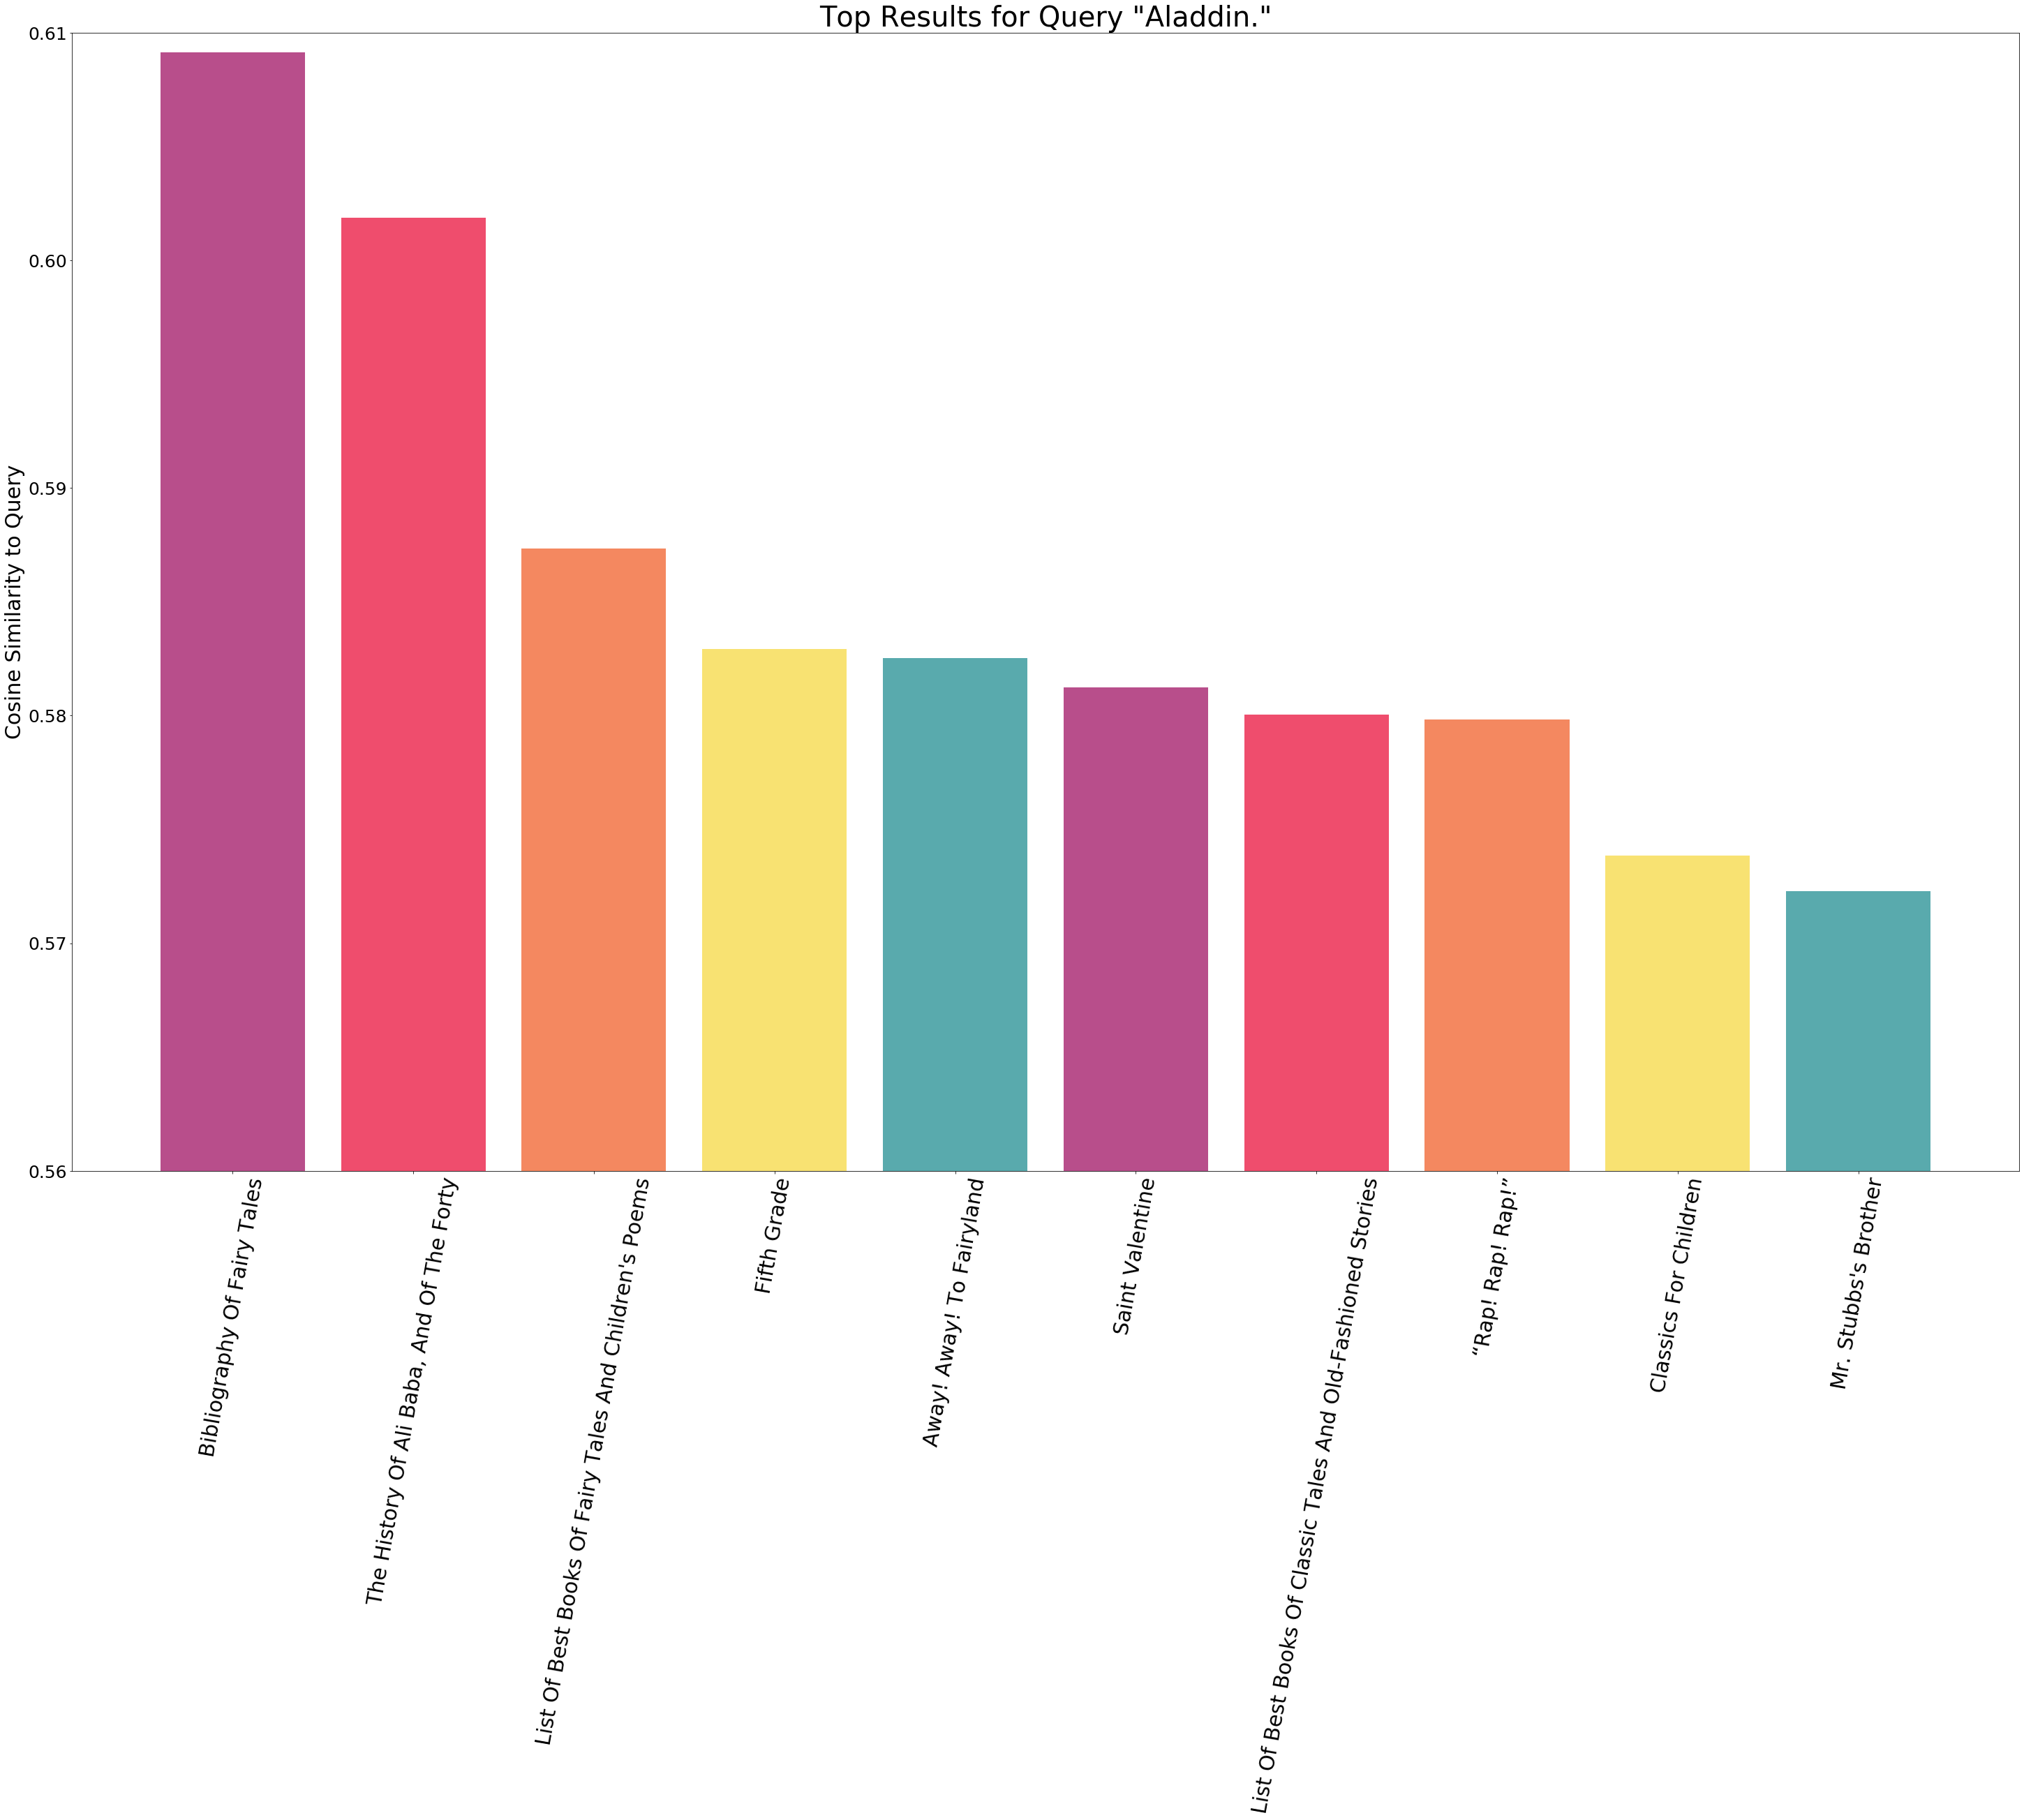

In [153]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(query_index, query_values, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.56,0.61])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(query_index, rotation=80,fontsize=30)
plt.yticks(fontsize=25)
axs.set_title('Top Results for Query "Aladdin."', fontsize=40)
plt.show()
fig.savefig('aladdinquery.png')

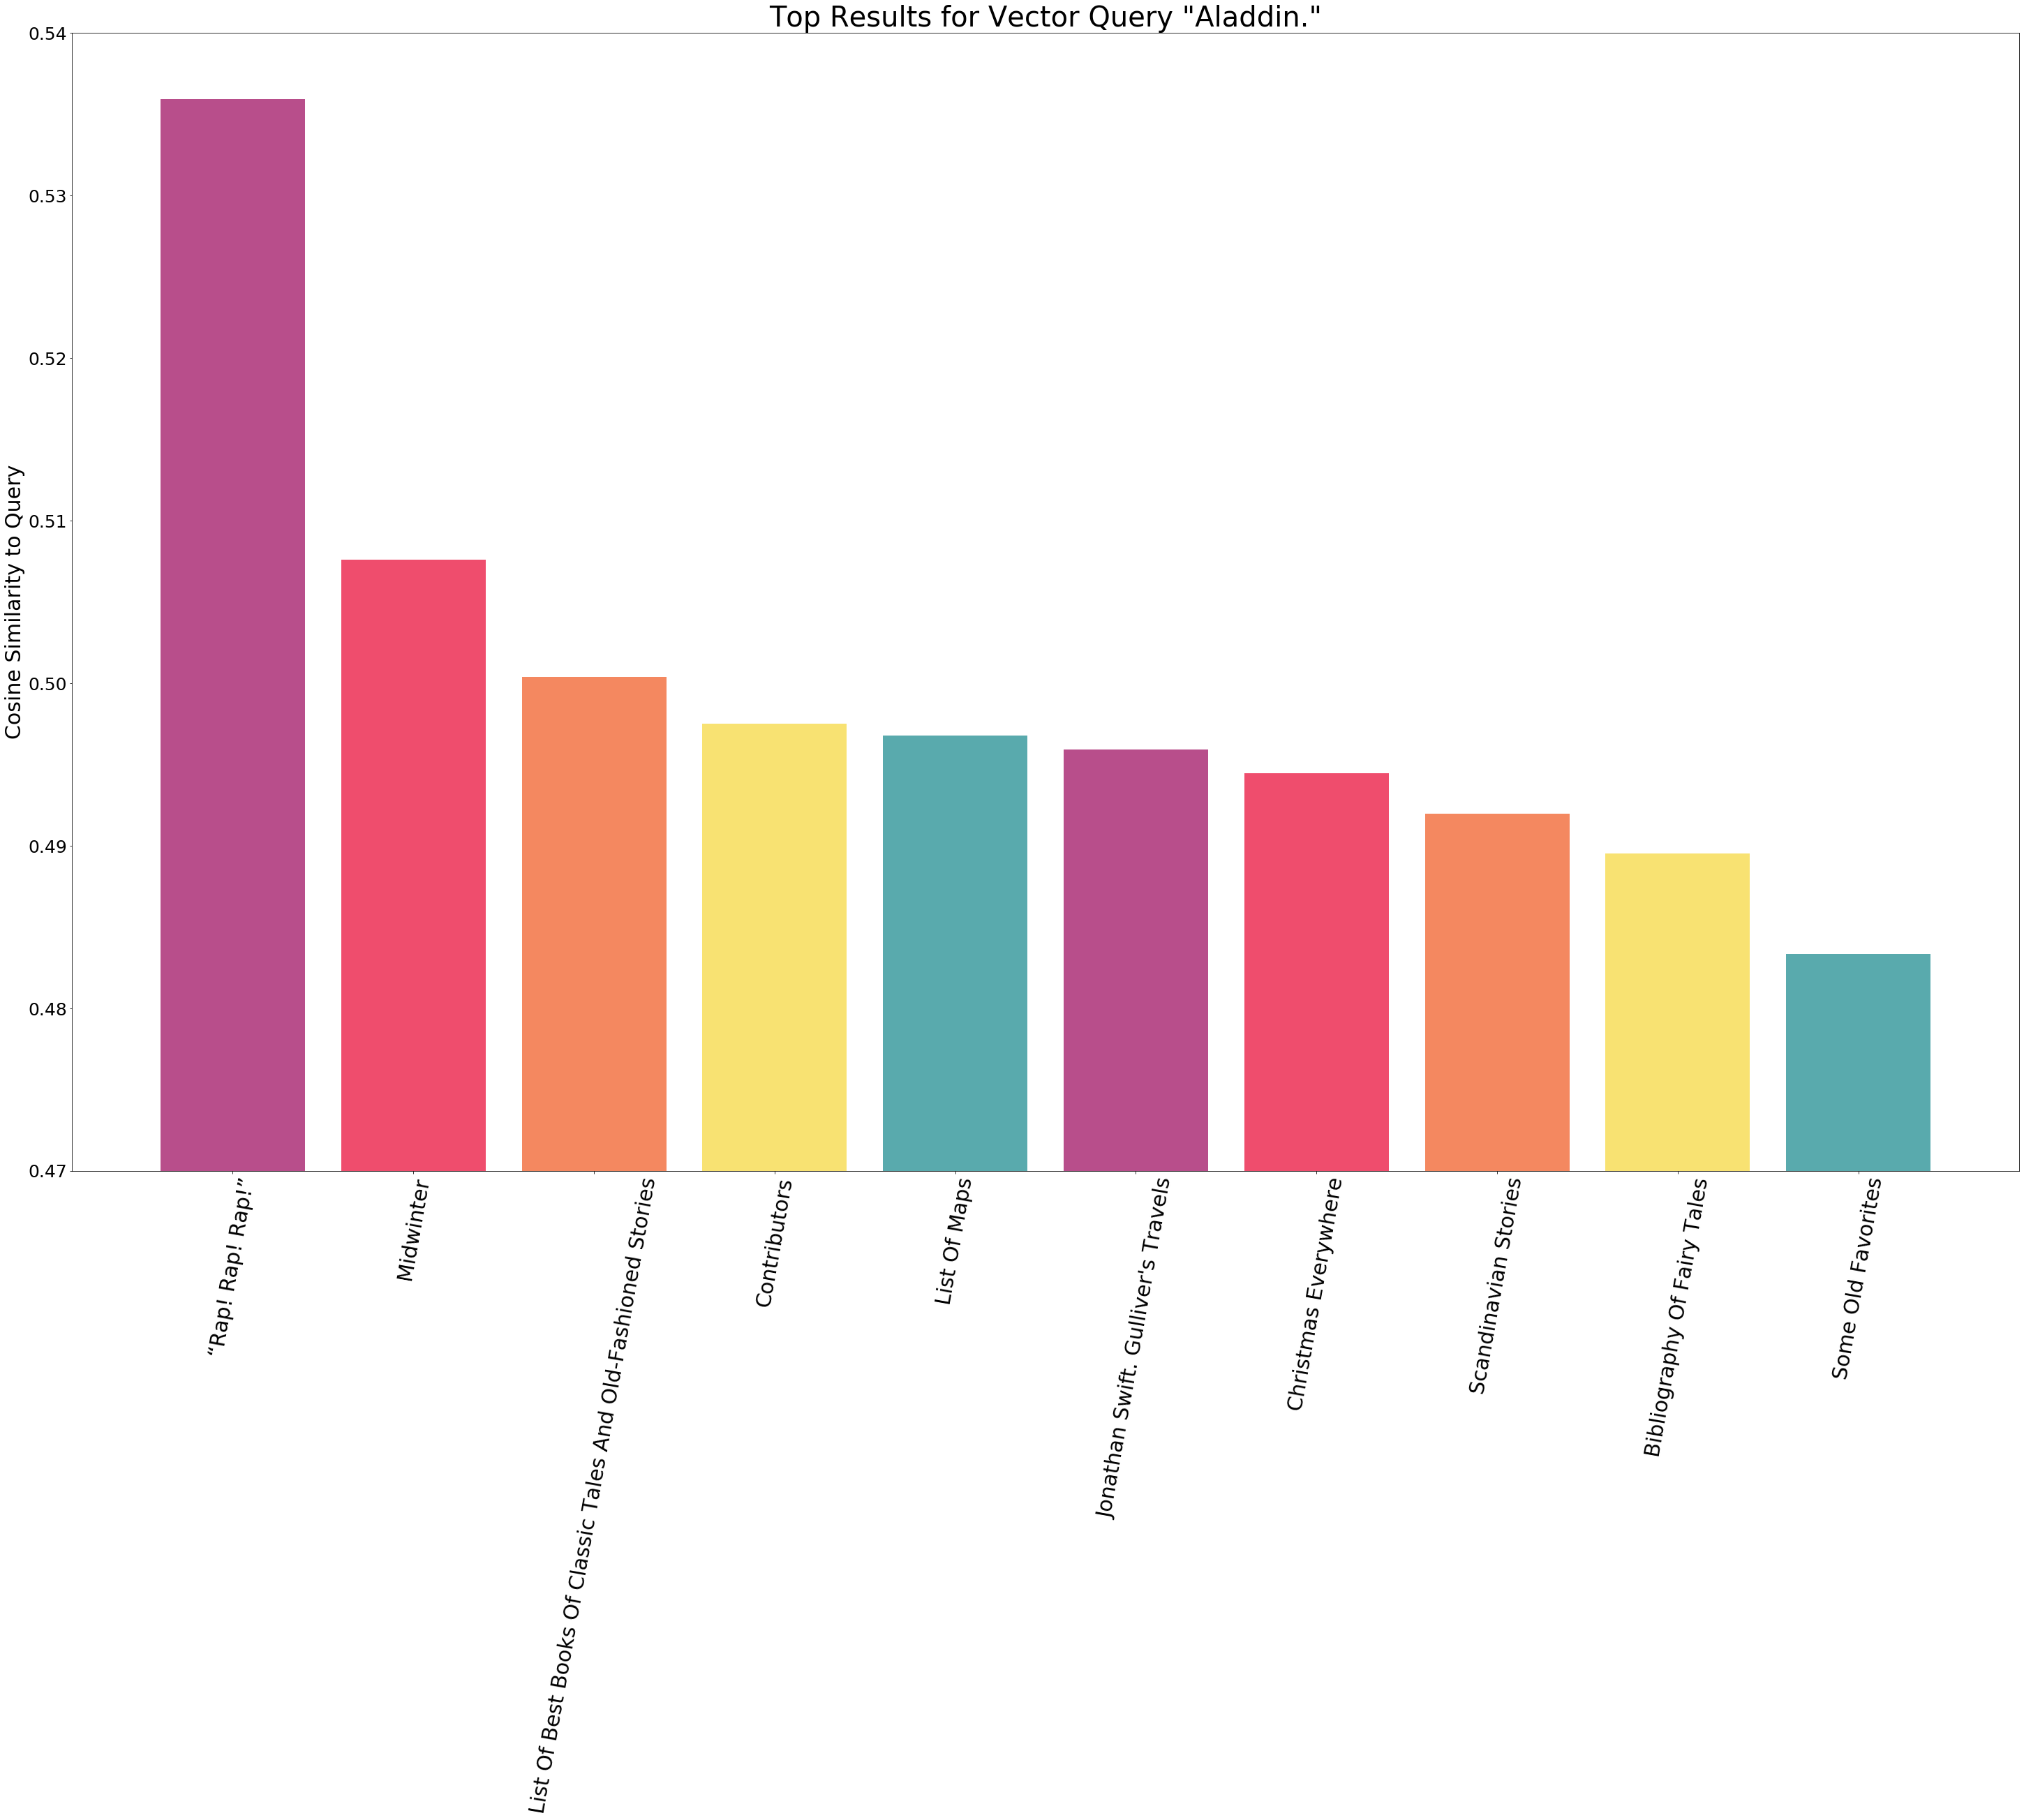

In [155]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(vector_index, vector_values, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.47,0.54])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(vector_index, rotation=80,fontsize=30)
plt.yticks(fontsize=25)
axs.set_title('Top Results for Vector Query "Aladdin."', fontsize=40)
plt.show()
fig.savefig('aladdinvectorquery.png')

In [158]:
boolean_values

[0.999986469745636,
 0.9999854564666748,
 0.9996551871299744,
 0.996408998966217,
 0.9950186610221863,
 0.9913046360015869,
 0.9907914400100708,
 0.9904690384864807,
 0.9892946481704712,
 0.9878783226013184]

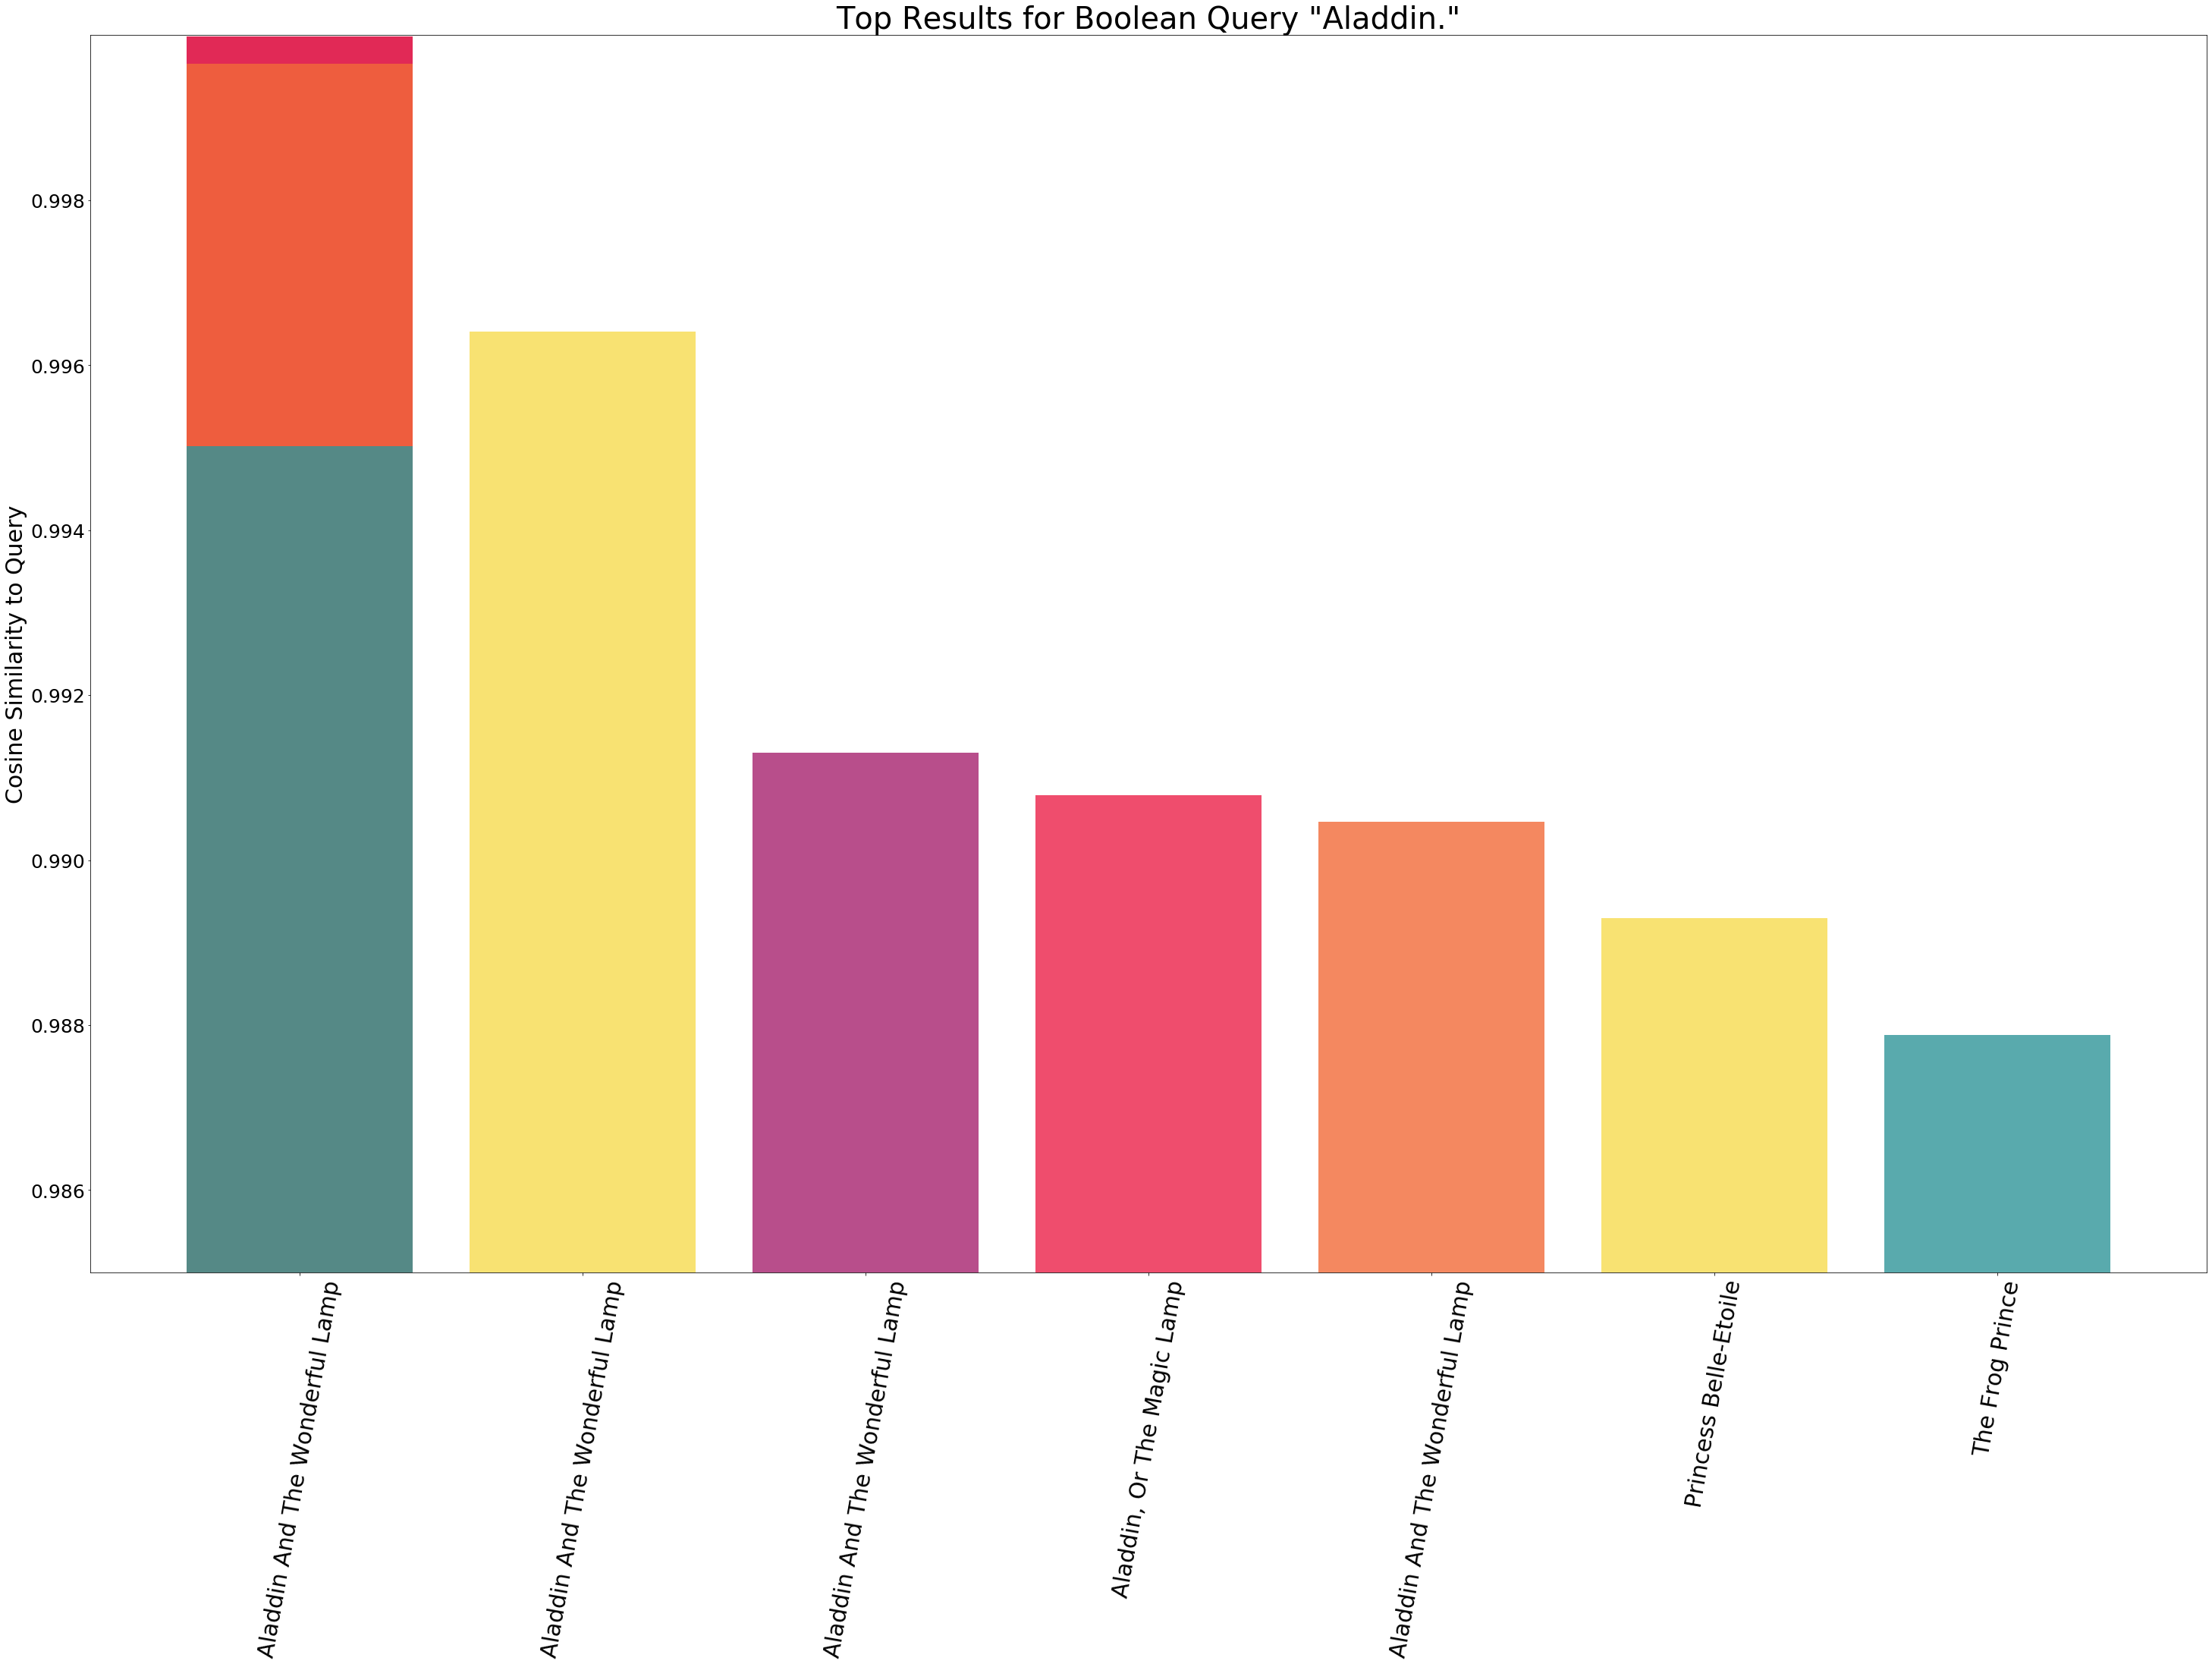

In [163]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(boolean_index, boolean_values, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.985,0.9999999999])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(boolean_index, rotation=80,fontsize=30)
plt.yticks(fontsize=25)
axs.set_title('Top Results for Boolean Query "Aladdin."', fontsize=40)
plt.show()
fig.savefig('aladdinbooleanquery.png')

#### Out of Corpus query

In [ ]:

results=query('computer')
[(df.loc[i[0], 'story_title'], i[1]) for i in results]

In [ ]:
results=word_in_title_query('computer')
[(df.loc[i[0], 'story_title'], i[1]) for i in results]

In [164]:
user_input= 'computer'
query_computer=[(df.loc[result[0], 'story_title'], result[1]) for result in query('computer')[:10]]

In [165]:
user_input= 'computer'
title_query_computer=[(df.loc[result[0], 'story_title'], result[1]) for result in word_in_title_query('computer')[:10]]

In [167]:
query_computer_index= [title for title, value in query_computer]
query_computer_values= [value for title, value in query_computer]

title_computer_index= [title for title, value in title_query_computer]
title_computer_values= [value for title, value in title_query_computer]

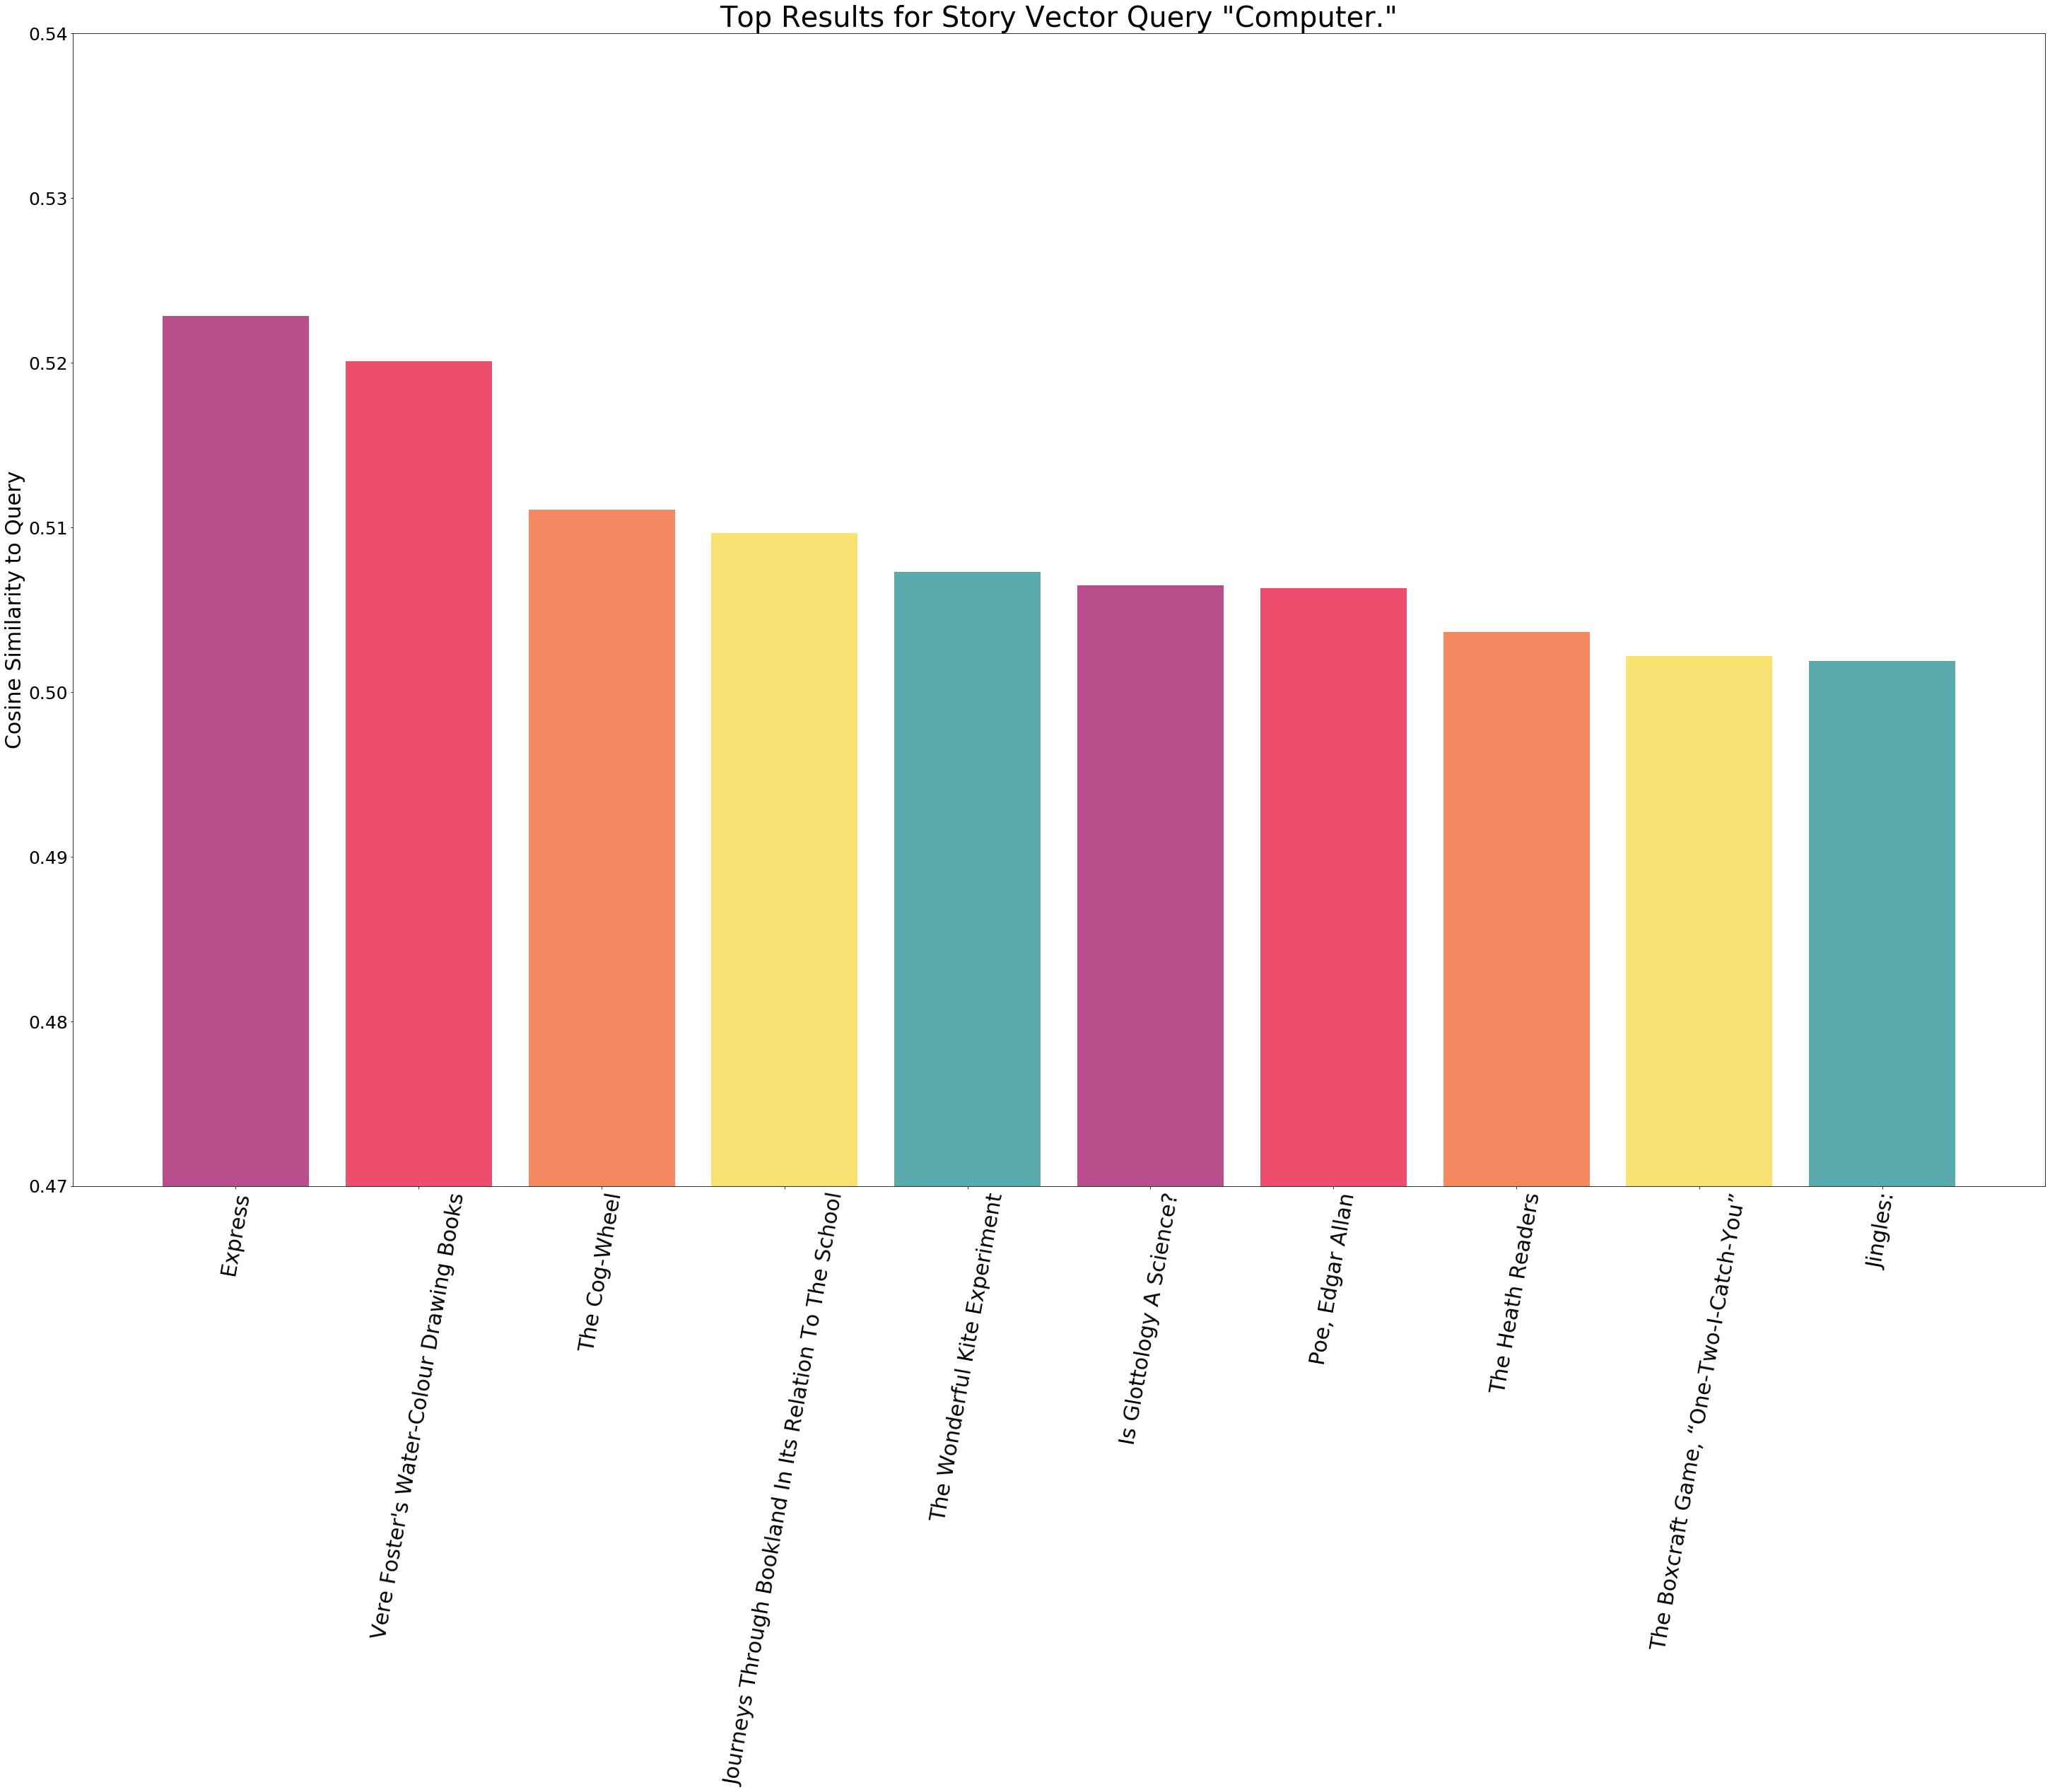

In [168]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(query_computer_index, query_computer_values, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.47,0.54])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(query_computer_index, rotation=80,fontsize=30)
plt.yticks(fontsize=25)
axs.set_title('Top Results for Story Vector Query "Computer."', fontsize=40)
plt.show()
fig.savefig('computerquery.png')

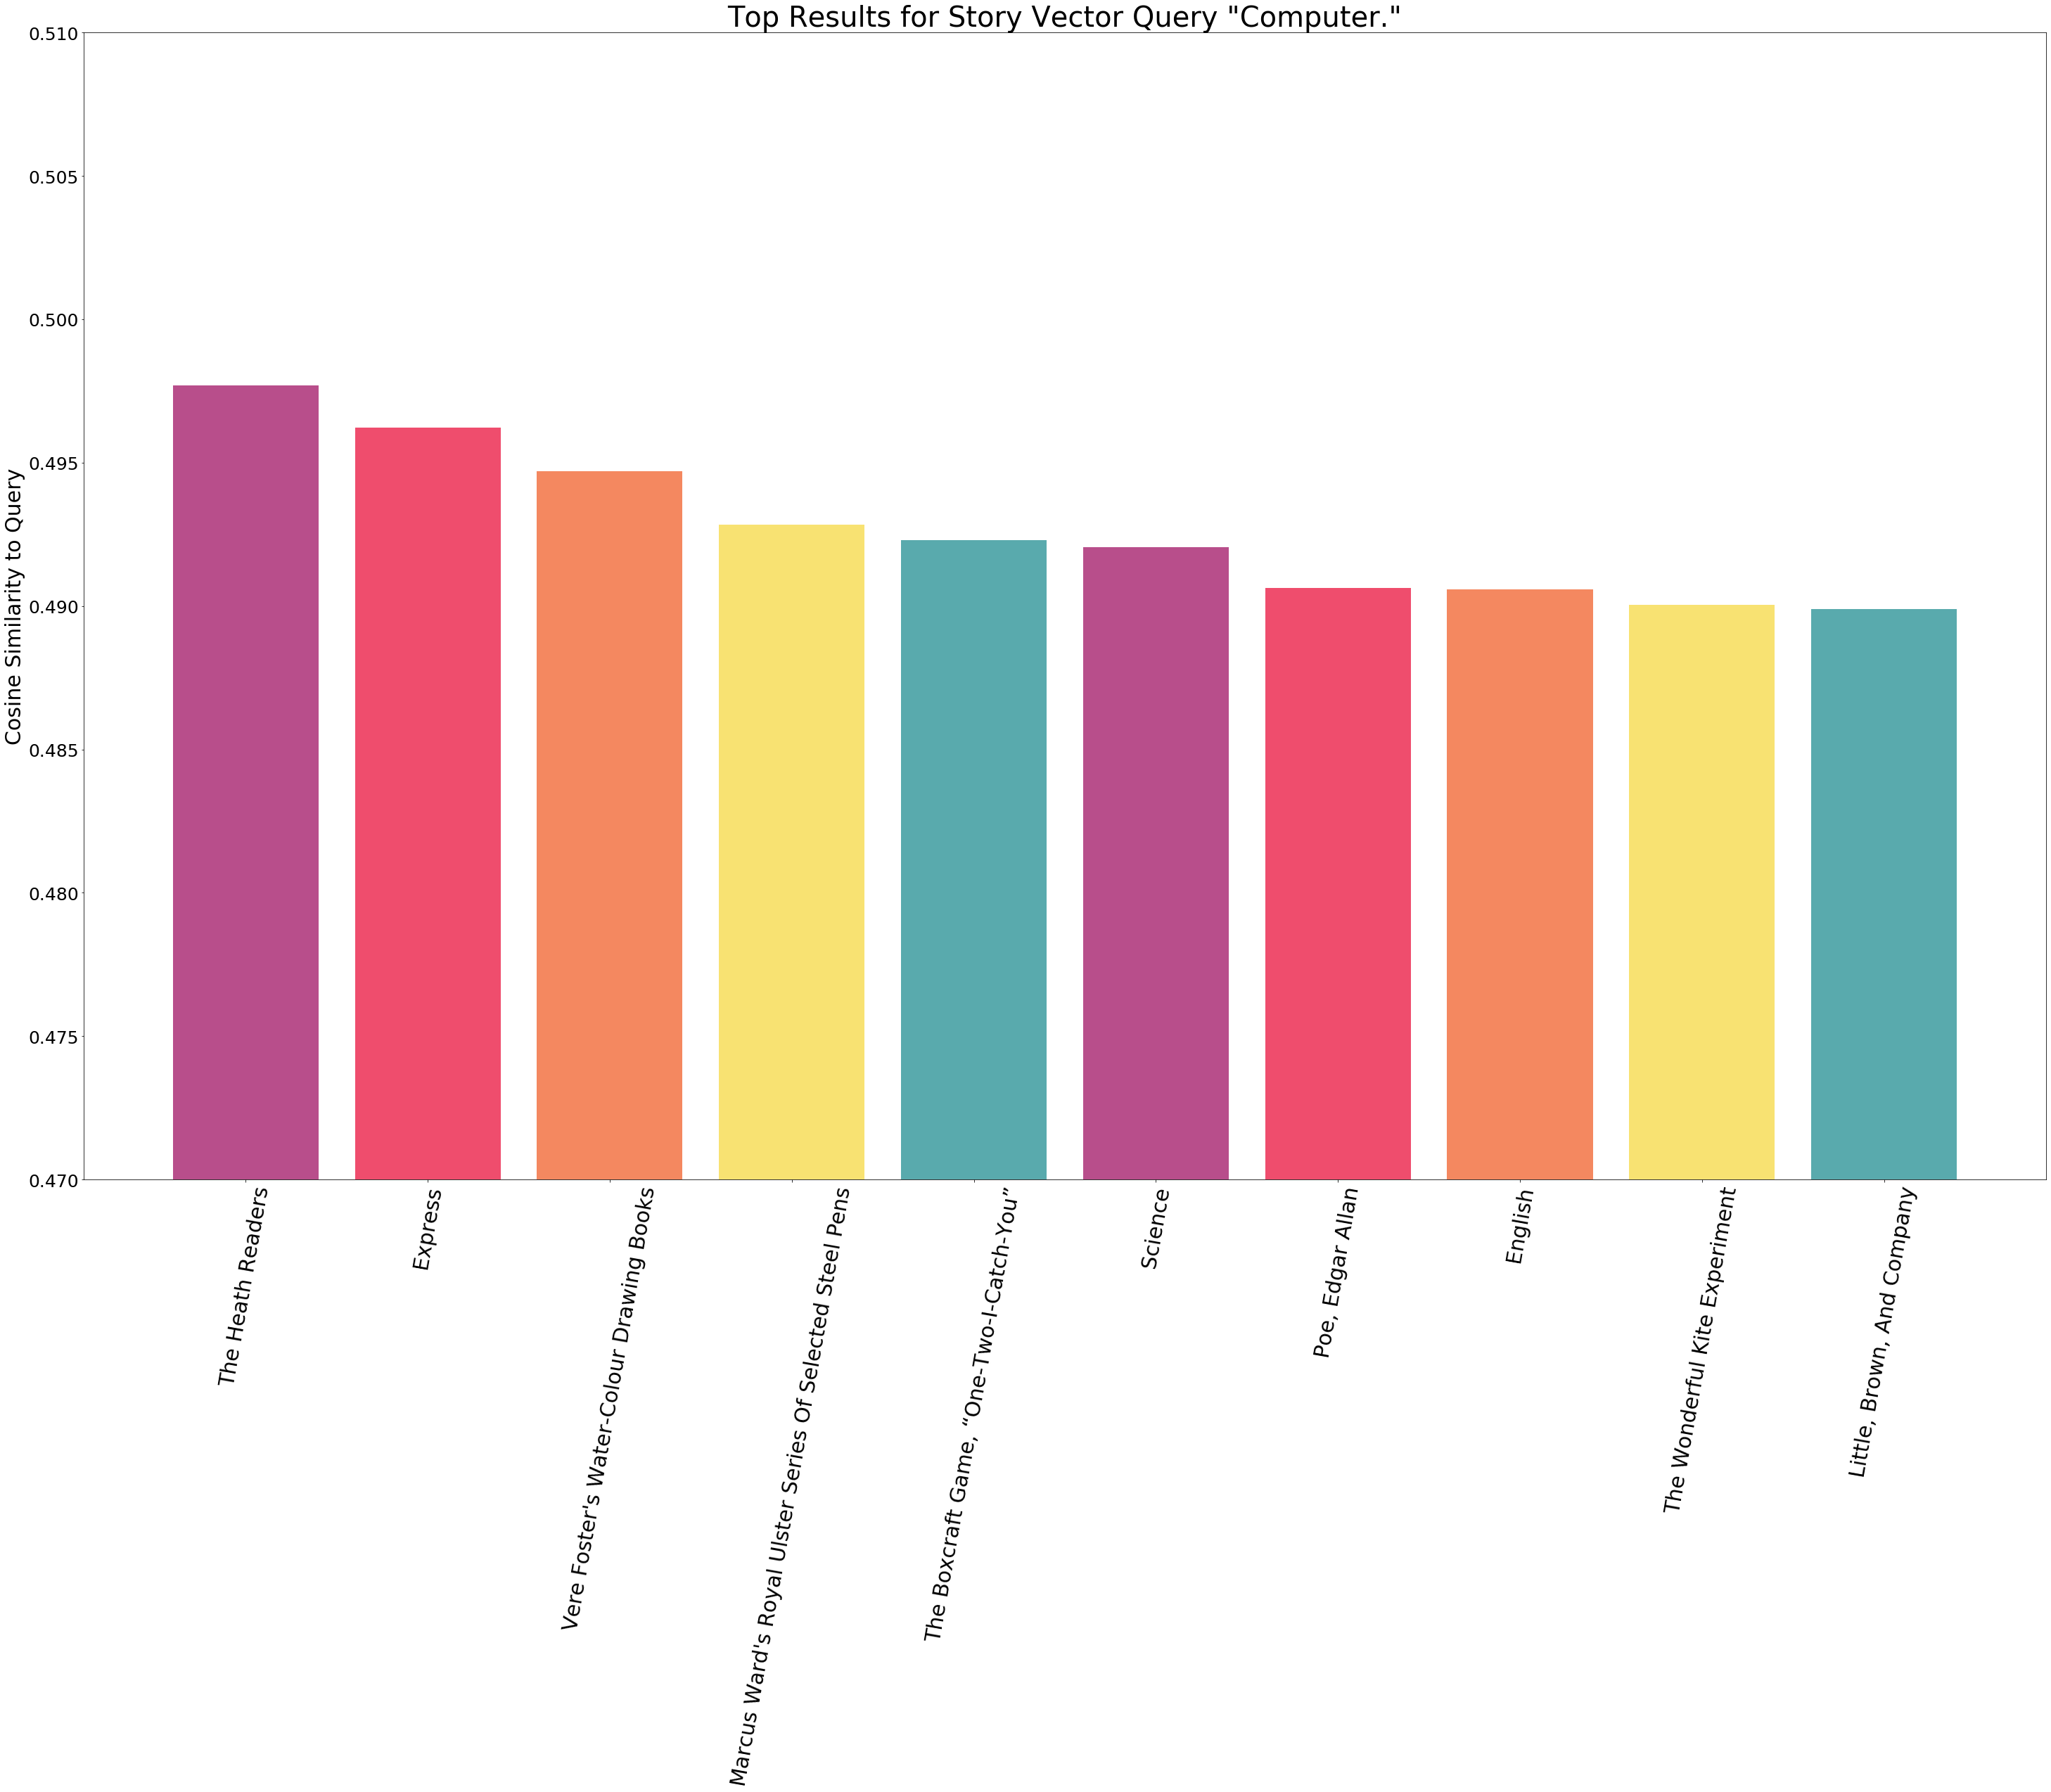

In [170]:
fig, axs=plt.subplots(nrows=1, ncols=1, figsize=[50,30])
axs.bar(title_computer_index, title_computer_values, alpha=0.8, color=['#A7226E', '#EC2049', '#F26B38', '#F7DB4F', '#2F9599'])
axs.set_ylim([0.47,0.51])
axs.set_ylabel('Cosine Similarity to Query', fontsize=30)
axs.set_xticklabels(title_computer_index, rotation=80,fontsize=30)
plt.yticks(fontsize=25)
axs.set_title('Top Results for Story Vector Query "Computer."', fontsize=40)
plt.show()
fig.savefig('computertitlequery.png')

### Final Single Word Query Function

In [166]:
def single_word_query(user_input):
    try:
        top_result=[i for i in df.index if user_input.lower() in df.loc[i, 'story_title'].lower().split(' ')][0]
        return find_similar_stories(top_result)
    except IndexError:
        doc = nlp(user_input)
        input_vector=doc.vector
        unsorted_sim=[(i, similarity(input_vector, df.loc[i, 'vectors'])) for i in df.index if df.loc[i, 'word_count']>100]
        results=sorted(unsorted_sim, key=lambda x: x[1], reverse=True)
        return results
    

## Improving the Short Query Function

Now that we have a workable solution to the initial problem of querying "Aladdin" and not getting back the Aladdin story as well as querying words not in the corpus, we have a new problem, which is how to handle queries that are not complete sentences. A sentence comprises of a noun or a verb, however our current nlp model does not have the tokenizer added in order to save space.  

In [129]:
nlp.pipe_names

[]

# Improved Sampler

In [ ]:
### Original sampler
def sample_results(results, n=12):
    strong_options=results[:n]
    medium_options=results[n:2*n]
    weak_options=results[2*n:3*n]
    
    sampled_items=[]
    for index in range(n//3):
        new_group= [strong_options[random.randint(0,n-1)], weak_options[random.randint(0,n-1)], medium_options[random.randint(0,n-1)]]
        sampled_items+=new_group
    return sampled_items